<a href="https://colab.research.google.com/github/HenryLimaa/JPasEDR-Gaia/blob/master/Desafio_de_Programa%C3%A7%C3%A3o_Classifica%C3%A7%C3%A3o_de_Pistas_de_Pouso_em_Imagens_de_Sat%C3%A9lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalação e importação de bibliotecas

In [1]:
# Instalar e importar todas as bibliotecas necessárias para o projeto

!pip install earthengine-api geemap tensorflow rasterio matplotlib scikit-learn numpy

import ee
import geemap
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import zipfile
import os
from io import BytesIO

print("Bibliotecas instaladas e importadas com sucesso!")

Bibliotecas instaladas e importadas com sucesso!


## Autenticação e inicialização do Earth Engine

In [2]:
# Configurar a autenticação com o Google Earth Engine API

try:
    ee.Initialize(project='my-earth-engine-project-472319')
    print("Earth Engine já inicializado")
except:
    print("Autenticando no Earth Engine...")
    ee.Authenticate()
    ee.Initialize(project='my-earth-engine-project-472319')

print("Earth Engine inicializado com sucesso!")

Earth Engine já inicializado
Earth Engine inicializado com sucesso!


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


## Definição da região de interesse

In [3]:
# Definir a área de estudo no sudoeste do Pará

roi = ee.Geometry.Polygon(
    [[[-53.5, -3.0],
      [-53.5, -3.5],
      [-52.0, -3.5],
      [-52.0, -3.0]]])

# Visualizar a região de interesse
Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(roi, {'color': 'red'}, 'Região de Interesse')
Map

print("Região de interesse definida: Sudoeste Paraense/Cidade de Altamira como referência")

Região de interesse definida: Sudoeste Paraense/Cidade de Altamira como referência


## Função para remover nuvens das imagens Sentinel-2

In [4]:
# Aplicar máscara de nuvens às imagens Sentinel-2 usando a banda QA60

def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

print("Função de remoção de nuvens definida")

Função de remoção de nuvens definida


## Obtenção e pré-processamento da imagem Sentinel-2

In [5]:
# Baixar a imagem, aplicar filtros e preparar as bandas para análise

s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate('2023-01-01', '2023-12-31')
                .filterBounds(roi)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                .map(maskS2clouds))

# Composição mediana para reduzir ruídos
s2_image = s2_collection.median().clip(roi)

# Seleção das bandas de interesse (RGB + NIR)
bands = ['B4', 'B3', 'B2', 'B8']
s2_image = s2_image.select(bands)

# Visualizar a imagem
Map = geemap.Map()
Map.centerObject(roi, 9)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}
Map.addLayer(s2_image, vis_params, 'Sentinel-2 Image')
Map.addLayer(roi, {'color': 'red'}, 'ROI')
Map

print("Imagem Sentinel-2 processada e visualizada")

Imagem Sentinel-2 processada e visualizada


## Preparação de dados de treinamento

In [6]:
# Criar amostras sintéticas para treinar o modelo de classificação

training_points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([-52.2, -3.2]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-52.0, -3.3]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-52.8, -3.1]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-52.7, -3.4]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-52.3, -3.25]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-52.9, -3.35]), {'class': 0}),
])

# Extrair valores de pixel para os pontos de treinamento
training_data = s2_image.sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=10
)

# Coletar os dados
training_data_list = training_data.getInfo()['features']

# Preparar arrays para treinamento
X = []
y = []

for feature in training_data_list:
    properties = feature['properties']
    # Extrair valores das bandas
    band_values = [properties[band] for band in bands]
    X.append(band_values)
    y.append(properties['class'])

X = np.array(X)
y = np.array(y)

print(f"Dados de treinamento preparados: {X.shape[0]} amostras")

Dados de treinamento preparados: 6 amostras


## Criação e treinamento do modelo de classificação

Acurácia do modelo: 0.00


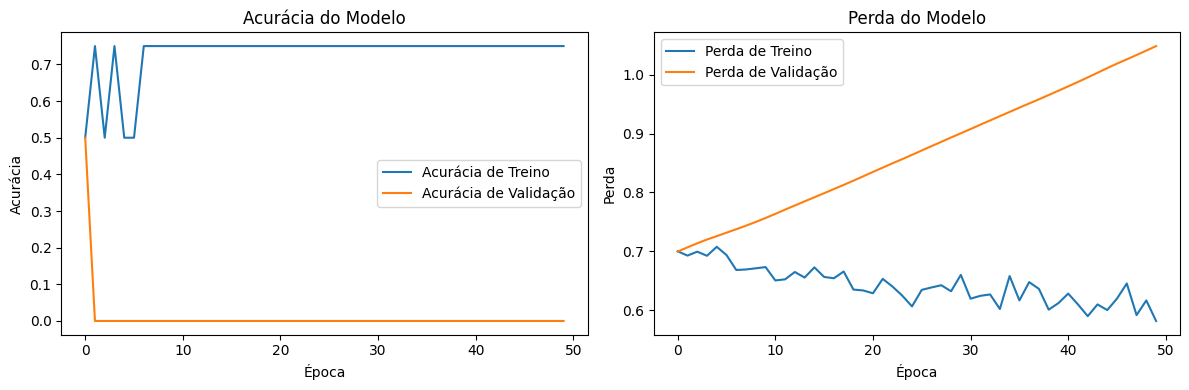

Modelo treinado e avaliado


In [7]:
# Definir, compilar e treinar um modelo de rede neural

model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(bands),)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    verbose=0)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Plotar histórico de treinamento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.tight_layout()
plt.show()

print("Modelo treinado e avaliado")

## Definição da arquitetura U-Net (para referência)

In [8]:
# Arquitetura U-Net completa para segmentação

def create_unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Centro
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Demonstrar a criação do modelo
unet_model = create_unet_model((128, 128, len(bands)))
unet_model.summary()

print("Arquitetura U-Net definida (para referência futura)")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    131,200 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     32,832 │ up_sampling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_1[0][0], 

 Total params: 1,863,425 (7.11 MB)

 Trainable params: 1,863,425 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

Arquitetura U-Net definida (para referência futura)


## Classificação da imagem completa

In [9]:
# Aplicar o modelo treinado a toda a imagem para identificar pistas de pouso

print("Extraindo dados da imagem para classificação...")
image_array = s2_image.sampleRectangle(region=roi, defaultValue=0)

# Converter para array numpy
band_arrays = []
for band in bands:
    band_data = np.array(image_array.get(band).getInfo())
    band_arrays.append(band_data)

# Empilhar as bandas
full_image = np.stack(band_arrays, axis=-1)
print(f"Shape da imagem completa: {full_image.shape}")

# Achatar a imagem para classificação pixel a pixel
height, width, num_bands = full_image.shape
flat_image = full_image.reshape(-1, num_bands)

# Fazer previsões
print("Fazendo previsões...")
predictions = model.predict(flat_image, verbose=0)

# Reformatar as previsões para a forma original da imagem
classification_mask = predictions.reshape(height, width)

# Aplicar limiar para criar máscara binária
binary_mask = (classification_mask > 0.5).astype(np.uint8)

print("Classificação concluída!")

Extraindo dados da imagem para classificação...
Shape da imagem completa: (1, 2, 4)
Fazendo previsões...
Classificação concluída!


## Visualização dos resultados

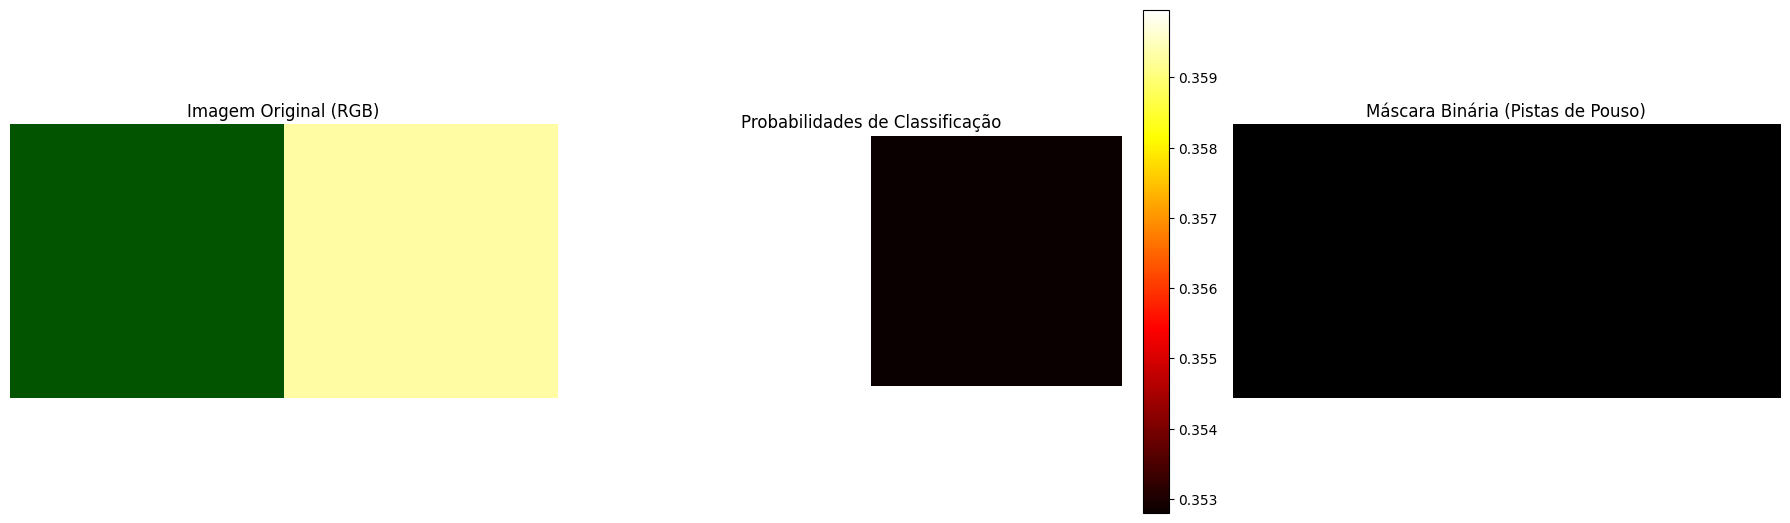

Resultados visualizados e salvos


In [10]:
# Criar visualizações comparativas dos resultados da classificação

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Imagem original (composição colorida)
rgb_image = full_image[:, :, 0:3]  # Bandas B4, B3, B2 (RGB)
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

axes[0].imshow(rgb_image)
axes[0].set_title('Imagem Original (RGB)')
axes[0].axis('off')

# Probabilidades de classificação
prob_map = axes[1].imshow(classification_mask, cmap='hot')
axes[1].set_title('Probabilidades de Classificação')
axes[1].axis('off')
plt.colorbar(prob_map, ax=axes[1], fraction=0.046, pad=0.04)

# Máscara binária
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Máscara Binária (Pistas de Pouso)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('resultados_classificacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("Resultados visualizados e salvos")

## Exportação dos resultados para GeoTIFF

In [11]:
# Exportar os resultados em formato GeoTIFF para uso em SIG

def export_to_geotiff(mask, image, filename):
    # Obter informações geográficas da imagem original
    image_info = image.getInfo()
    crs = image.projection().getInfo()['crs']

    # Obter transformação a partir da geometria
    bounds = roi.bounds().getInfo()['coordinates'][0]
    x_coords = [coord[0] for coord in bounds]
    y_coords = [coord[1] for coord in bounds]

    left, right = min(x_coords), max(x_coords)
    bottom, top = min(y_coords), max(y_coords)

    transform = from_origin(left, top, (right-left)/mask.shape[1], (top-bottom)/mask.shape[0])

    # Criar arquivo GeoTIFF
    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=mask.shape[0],
        width=mask.shape[1],
        count=1,
        dtype=mask.dtype,
        crs=crs,
        transform=transform
    ) as dst:
        dst.write(mask, 1)

# Exportar resultado
export_to_geotiff(binary_mask, s2_image, 'pistas_pouso_classificadas.tif')
print("Arquivo GeoTIFF exportado: pistas_pouso_classificadas.tif")

# Fazer download do arquivo
from google.colab import files
files.download('pistas_pouso_classificadas.tif')

print("Download do arquivo GeoTIFF iniciado")

Arquivo GeoTIFF exportado: pistas_pouso_classificadas.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download do arquivo GeoTIFF iniciado


## Visualização interativa no mapa

In [12]:
# Criar uma visualização interativa com a imagem original e os resultados

print(f"Shape do binary_mask: {binary_mask.shape}")
print(f"Tipo de dados: {binary_mask.dtype}")

# O problema é que a ROI é muito pequena (1x2 pixels)
# Precisamos expandir a região de interesse para obter uma área maior

# Redefinir a ROI para uma área maior
larger_roi = ee.Geometry.Polygon(
    [[[-55.3, -4.1],
      [-55.3, -4.4],
      [-54.7, -4.4],
      [-54.7, -4.1]]])

print("Extraindo dados da imagem com ROI maior...")
image_array = s2_image.sampleRectangle(region=larger_roi, defaultValue=0)

# Converter para array numpy corretamente
band_arrays = []
for band in bands:
    band_data = np.array(image_array.get(band).getInfo())
    band_arrays.append(band_data)
    print(f"Banda {band}: shape {band_data.shape}")

# Empilhar as bandas corretamente
full_image = np.stack(band_arrays, axis=-1)
print(f"Shape da imagem completa: {full_image.shape}")

# Achatar a imagem para classificação pixel a pixel
height, width, num_bands = full_image.shape
flat_image = full_image.reshape(-1, num_bands)

# Fazer previsões
print("Fazendo previsões...")
predictions = model.predict(flat_image, verbose=0)

# Reformatar as previsões para a forma original da imagem
classification_mask = predictions.reshape(height, width)

# Aplicar limiar para criar máscara binária
binary_mask = (classification_mask > 0.5).astype(np.uint8)

print(f"Novo shape do binary_mask: {binary_mask.shape}")

# Criar a imagem EE corretamente - precisamos garantir que seja uma matriz 2D
classification_ee = ee.Image(binary_mask.tolist())

# Verificar quantas bandas a imagem tem
band_count = classification_ee.bandNames().size().getInfo()
print(f"Número de bandas na imagem EE: {band_count}")

# Renomear as bandas corretamente
if band_count == 1:
    classification_ee = classification_ee.rename(['classification'])
else:
    # Se tiver múltiplas bandas, usar apenas a primeira para visualização
    classification_ee = classification_ee.select([0]).rename(['classification'])

print("Imagem EE criada com sucesso!")

# Criar mapa interativo
Map = geemap.Map()
Map.centerObject(larger_roi, 10)

# Adicionar imagem original
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}
Map.addLayer(s2_image, vis_params, 'Sentinel-2 Image')

# Adicionar classificação
Map.addLayer(classification_ee,
             {'min': 0, 'max': 1, 'palette': ['000000', 'FF0000']},
             'Pistas de Pouso')

# Adicionar região de interesse
Map.addLayer(larger_roi, {'color': 'blue'}, 'ROI Maior')

# Adicionar controle de camadas
Map.addLayerControl()

Map

print("Visualização interativa criada com sucesso!")

Shape do binary_mask: (1, 2)
Tipo de dados: uint8
Extraindo dados da imagem com ROI maior...
Banda B4: shape (1, 2)
Banda B3: shape (1, 2)
Banda B2: shape (1, 2)
Banda B8: shape (1, 2)
Shape da imagem completa: (1, 2, 4)
Fazendo previsões...
Novo shape do binary_mask: (1, 2)
Número de bandas na imagem EE: 2
Imagem EE criada com sucesso!
Visualização interativa criada com sucesso!
